# Rapport Groupe 15

In [1]:
import os
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow.keras as keras
import numpy as np
import datetime
import platform
from ctypes import *
import tqdm
import json
from PIL import Image
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:
def get_lib():
    path_to_shared_library = "target/release/librust_lib.dylib"
    path_to_shared_library_windows = "target\\debug\\rust_lib.dll"

    if platform.system() == 'Windows':
        my_lib = cdll.LoadLibrary(path_to_shared_library_windows)
    else:
        my_lib = cdll.LoadLibrary(path_to_shared_library)
    return my_lib

In [3]:
def toList(arr):
    return [j for i in arr for j in i]

Le but de ce rapport est de démontrer les résultats que nous avons pu obtenir après 4 mois de travail. L'objectif de notre projet était de pouvoir déterminer le genre d'un film à partir de son affiche. Nous avons décidé de coder les différents algorithmes en Rust. 
La lecture de ce rapport permettra de voir comment certains de nos algorithmes fonctionnent comparé à ceux du framework Tensorflow ainsi que d'expliquer le raisonnement pour lequel nous avons choisi un algorithme plutôt que les autres pour notre application web. 

Afin de pouvoir faciliter la réalisation de nos graphiques et la lisibilité du code nous avons utilisé des classes que l'on appelle des wrapper. Ces wrappers vont nous permettre de pouvoir utiliser des métriques qui ont été implémenté dans la lib sklearn. Cela va nous permettre une meilleure représentation de nos résultats. 

In [4]:
class MySKLearnRBFRawWrapper:
    def __init__(self, centers, X, input_dim, gamma, alpha: float = 0.01, iteration_count: int = 1000):
        self.lib = get_lib()
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        inputs_type = c_float * len(X)
        self.lib.create_rbf_model.argtypes = [c_int, inputs_type, c_int, c_int, c_float]
        self.lib.create_rbf_model.restype = c_void_p
        self.model = self.lib.create_rbf_model(centers, inputs_type(*X), len(X), input_dim, gamma)
        self.alpha = alpha
        self.iteration_count = iteration_count
        self.input_dim = input_dim

    def lloyd(self, X):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        x_type = c_float * len(X)
        self.lib.lloyd.argtypes = [c_void_p, x_type, c_int]
        self.lib.lloyd.restype = None
        self.lib.lloyd(self.model, x_type(*X), len(X))

    def fit(self, X, Y):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if not hasattr(Y, 'shape'):
            Y = np.array(Y)
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        Y = Y.flatten()
        Y = Y.tolist()
        inputs_type = c_float * len(X)
        outputs_type = c_float * len(Y)
        inputs_native = inputs_type(*X)
        outputs_native = outputs_type(*Y)
        self.lib.train_rbf_model_classification.argtypes = [c_void_p, inputs_type, outputs_type, c_int, c_int, c_int,
                                                            c_float]
        self.lib.train_rbf_model_classification.restype = None
        self.lib.train_rbf_model_classification(self.model, inputs_native, outputs_native, len(X), len(Y),
                                                self.iteration_count, self.alpha)

    def predict(self, X):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        results = []
        sample_inputs_type = c_float * self.input_dim
        self.lib.predict_rbf_model_classification.argtypes = [c_void_p, sample_inputs_type]
        self.lib.predict_rbf_model_classification.restype = c_float
        for x in X:
            results.append(
                self.lib.predict_rbf_model_classification(self.model, sample_inputs_type(*x)))
        return np.array(results)

    def save(self, filename):
        self.lib.save_rbf_model.argtypes = [c_void_p, c_char_p]
        self.lib.save_rbf_model.restype = None
        self.lib.save_rbf_model(self.model, filename.encode("utf-8"))

    def destroy(self):
        self.lib.destroy_rbf_model.argtypes = [c_void_p]
        self.lib.destroy_rbf_model.restype = None
        self.lib.destroy_rbf_model(self.model)

In [5]:
class MySKLearnMLPRawWrapper:
    def __init__(self, npl: [int], classification: bool = True, alpha: float = 0.01, iteration_count: int = 1000):
        self.lib = get_lib()
        arr_type = c_int * len(npl)
        self.lib.create_mlp_model.argtypes = [arr_type, c_int]
        self.lib.create_mlp_model.restype = c_void_p
        self.model = self.lib.create_mlp_model(arr_type(*npl), len(npl))
        self.classification = classification
        self.alpha = alpha
        self.iteration_count = iteration_count

    def fit(self, X, Y):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if not hasattr(Y, 'shape'):
            Y = np.array(Y, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=0)
        X = X.flatten()
        X = X.tolist()
        X = toList(X)
        Y = Y.flatten()
        Y = Y.tolist()
        inputs_type = c_float * len(X)
        outputs_type = c_float * len(Y)
        inputs_native = inputs_type(*X)
        outputs_native = outputs_type(*Y)
        self.lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p, inputs_type, outputs_type,
                                                                                c_float, c_int, c_int, c_int]
        self.lib.train_classification_stochastic_backdrop_mlp_model.restype = None
        self.lib.train_classification_stochastic_backdrop_mlp_model(self.model, inputs_native,
                                                                    outputs_native, self.alpha,
                                                                    self.iteration_count, len(X),
                                                                    len(Y))

    def predict(self, X, input_dim, output_dim):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        results = []
        sample_inputs_type = c_float * input_dim
        self.lib.predict_mlp_model_classification.argtypes = [c_void_p, sample_inputs_type, c_int]
        self.lib.predict_mlp_model_classification.restype = POINTER(c_float)
        for x in X:
            prediction = self.lib.predict_mlp_model_classification(self.model, sample_inputs_type(*x), input_dim)
            result = np.ctypeslib.as_array(prediction, (output_dim,))
            results.append(np.array(result))
        return np.array(results)

    def save(self, filename):
        self.lib.save_mlp_model.argtypes = [c_void_p, c_char_p]
        self.lib.save_mlp_model.restype = None
        self.lib.save_mlp_model(self.model, filename.encode("utf-8"))

    def destroy(self):
        self.lib.destroy_model.argtypes = [c_void_p]
        self.lib.destroy_model.restype = None
        self.lib.destroy_model(self.model)

In [6]:
class MySKLearnLinearModelWrapper:
    def __init__(self, array_size: int, iteration_count: int = 1000, alpha=0.01, classification: bool = True):
        self.lib = get_lib()
        self.lib.create_model.argtypes = [c_int]
        self.lib.create_model.restype = POINTER(c_float)
        self.model = self.lib.create_model(array_size)
        self.model_size = array_size + 1
        self.iteration_count = iteration_count
        self.alpha = alpha
        self.classification = classification

    def fit(self, X, Y, inputs_dim: int = 1, outputs_dim: int = 1):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if not hasattr(Y, 'shape'):
            Y = np.array(Y, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=0)
        X = X.flatten()
        X = X.tolist()
        X = toList(X)
        Y = Y.flatten()
        Y = Y.tolist()
        inputs_type = c_float * len(X)
        outputs_type = c_float * len(Y)
        inputs_native = inputs_type(*X)
        outputs_native = outputs_type(*Y)
        self.lib.train_rosenblatt_linear_model.argtypes = [type(self.model), inputs_type, outputs_type, c_int, c_float, c_int, c_int, c_int]
        self.lib.train_rosenblatt_linear_model.restype = None
        self.lib.train_regression_linear_model.argtypes = [type(self.model), inputs_type, outputs_type, c_int, c_int, c_int, c_int, c_int]
        self.lib.train_regression_linear_model.restype = None
        if self.classification:
            self.lib.train_rosenblatt_linear_model(self.model, inputs_native, outputs_native, self.iteration_count, self.alpha, self.model_size, len(X), len(Y))
        else:
            self.lib.train_regression_linear_model(self.model, inputs_native, outputs_native, self.model_size, len(X), len(Y), inputs_dim, outputs_dim)

    def predict(self, X, input_dim):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        results = []
        sample_inputs_type = c_float * input_dim
        self.lib.predict_linear_model_classification.argtypes = [type(self.model), sample_inputs_type, c_int, c_int]
        self.lib.predict_linear_model_classification.restype = c_float
        self.lib.predict_linear_model_regression.argtypes = [type(self.model), sample_inputs_type, c_int, c_int]
        self.lib.predict_linear_model_regression.restype = c_float
        if self.classification:
            for x in X:
                prediction = self.lib.predict_linear_model_classification(self.model, sample_inputs_type(*x), self.model_size, input_dim)
                results.append(prediction)
        else:
            for x in X:
                prediction = self.lib.predict_linear_model_regression(self.model, sample_inputs_type(*x), self.model_size, input_dim)
                results.append(prediction)
        return np.array(results)

    def destroy(self):
        self.lib.destroy_array.argtypes = [type(self.model), c_int]
        self.lib.destroy_array.restype = None
        self.lib.destroy_array(self.model, self.model_size)

## Comparaison du fonctionnement de notre librairie par rapport à Keras Tensorflow

Nous allons tout d'abord utiliser Keras afin de voir comment fonctionne le petit exemple que nous définissons

In [7]:
X_random = np.random.uniform(-1, 1.0, (110, 2))
Y_random = np.random.uniform(-1, 1.0, (110, 1))
model = keras.models.Sequential()
model.add(keras.layers.Dense(2, activation=keras.activations.tanh, input_dim=X_random.shape[-1]))
model.add(keras.layers.Dense(1, activation=keras.activations.tanh))
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss=keras.losses.mse)
h = model.fit(X_random, Y_random, batch_size=1, validation_split=0.1, epochs=1000)

Epoch 1/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.5801 - val_loss: 0.5771
Epoch 2/1000
99/99 [==============================] - 0s 657us/step - loss: 0.4728 - val_loss: 0.4268
Epoch 3/1000
99/99 [==============================] - 0s 669us/step - loss: 0.4157 - val_loss: 0.3928
Epoch 4/1000
99/99 [==============================] - 0s 669us/step - loss: 0.3926 - val_loss: 0.3405
Epoch 5/1000
99/99 [==============================] - 0s 737us/step - loss: 0.3793 - val_loss: 0.3005
Epoch 6/1000
99/99 [==============================] - 0s 714us/step - loss: 0.3786 - val_loss: 0.3020
Epoch 7/1000
99/99 [==============================] - 0s 684us/step - loss: 0.3710 - val_loss: 0.2599
Epoch 8/1000
99/99 [==============================] - 0s 640us/step - loss: 0.3660 - val_loss: 0.3172
Epoch 9/1000
99/99 [==============================] - 0s 694us/step - loss: 0.3723 - val_loss: 0.2671
Epoch 10/1000
99/99 [==============================] - 0s 620us/step - loss: 0.3693 

99/99 [==============================] - 0s 648us/step - loss: 0.3588 - val_loss: 0.2686
Epoch 160/1000
99/99 [==============================] - 0s 657us/step - loss: 0.3581 - val_loss: 0.2549
Epoch 161/1000
99/99 [==============================] - 0s 622us/step - loss: 0.3579 - val_loss: 0.2675
Epoch 162/1000
99/99 [==============================] - 0s 598us/step - loss: 0.3592 - val_loss: 0.2689
Epoch 163/1000
99/99 [==============================] - 0s 600us/step - loss: 0.3595 - val_loss: 0.2653
Epoch 164/1000
99/99 [==============================] - 0s 637us/step - loss: 0.3572 - val_loss: 0.2840
Epoch 165/1000
99/99 [==============================] - 0s 653us/step - loss: 0.3585 - val_loss: 0.2583
Epoch 166/1000
99/99 [==============================] - 0s 633us/step - loss: 0.3555 - val_loss: 0.2365
Epoch 167/1000
99/99 [==============================] - 0s 645us/step - loss: 0.3589 - val_loss: 0.2547
Epoch 168/1000
99/99 [==============================] - 0s 623us/step - loss: 0

Epoch 238/1000
99/99 [==============================] - 0s 633us/step - loss: 0.3581 - val_loss: 0.2536
Epoch 239/1000
99/99 [==============================] - 0s 626us/step - loss: 0.3579 - val_loss: 0.2448
Epoch 240/1000
99/99 [==============================] - 0s 625us/step - loss: 0.3587 - val_loss: 0.2659
Epoch 241/1000
99/99 [==============================] - 0s 617us/step - loss: 0.3575 - val_loss: 0.2519
Epoch 242/1000
99/99 [==============================] - 0s 590us/step - loss: 0.3584 - val_loss: 0.2670
Epoch 243/1000
99/99 [==============================] - 0s 621us/step - loss: 0.3571 - val_loss: 0.2709
Epoch 244/1000
99/99 [==============================] - 0s 609us/step - loss: 0.3576 - val_loss: 0.2512
Epoch 245/1000
99/99 [==============================] - 0s 633us/step - loss: 0.3585 - val_loss: 0.2472
Epoch 246/1000
99/99 [==============================] - 0s 668us/step - loss: 0.3593 - val_loss: 0.2599
Epoch 247/1000
99/99 [==============================] - 0s 656us

Epoch 317/1000
99/99 [==============================] - 0s 762us/step - loss: 0.3558 - val_loss: 0.2905
Epoch 318/1000
99/99 [==============================] - 0s 778us/step - loss: 0.3578 - val_loss: 0.2651
Epoch 319/1000
99/99 [==============================] - 0s 795us/step - loss: 0.3576 - val_loss: 0.2618
Epoch 320/1000
99/99 [==============================] - 0s 769us/step - loss: 0.3578 - val_loss: 0.2669
Epoch 321/1000
99/99 [==============================] - 0s 753us/step - loss: 0.3586 - val_loss: 0.2592
Epoch 322/1000
99/99 [==============================] - 0s 1ms/step - loss: 0.3575 - val_loss: 0.2480
Epoch 323/1000
99/99 [==============================] - 0s 721us/step - loss: 0.3589 - val_loss: 0.2591
Epoch 324/1000
99/99 [==============================] - 0s 752us/step - loss: 0.3575 - val_loss: 0.2761
Epoch 325/1000
99/99 [==============================] - 0s 820us/step - loss: 0.3582 - val_loss: 0.2659
Epoch 326/1000
99/99 [==============================] - 0s 672us/s

Epoch 396/1000
99/99 [==============================] - 0s 636us/step - loss: 0.3584 - val_loss: 0.2651
Epoch 397/1000
99/99 [==============================] - 0s 640us/step - loss: 0.3580 - val_loss: 0.2509
Epoch 398/1000
99/99 [==============================] - 0s 616us/step - loss: 0.3576 - val_loss: 0.2469
Epoch 399/1000
99/99 [==============================] - 0s 582us/step - loss: 0.3584 - val_loss: 0.2585
Epoch 400/1000
99/99 [==============================] - 0s 607us/step - loss: 0.3560 - val_loss: 0.2408
Epoch 401/1000
99/99 [==============================] - 0s 600us/step - loss: 0.3588 - val_loss: 0.2570
Epoch 402/1000
99/99 [==============================] - 0s 628us/step - loss: 0.3568 - val_loss: 0.2764
Epoch 403/1000
99/99 [==============================] - 0s 632us/step - loss: 0.3587 - val_loss: 0.2727
Epoch 404/1000
99/99 [==============================] - 0s 636us/step - loss: 0.3571 - val_loss: 0.2577
Epoch 405/1000
99/99 [==============================] - 0s 638us

Epoch 475/1000
99/99 [==============================] - 0s 653us/step - loss: 0.3590 - val_loss: 0.2436
Epoch 476/1000
99/99 [==============================] - 0s 1ms/step - loss: 0.3584 - val_loss: 0.2406
Epoch 477/1000
99/99 [==============================] - 0s 781us/step - loss: 0.3528 - val_loss: 0.2239
Epoch 478/1000
99/99 [==============================] - 0s 757us/step - loss: 0.3592 - val_loss: 0.2609
Epoch 479/1000
99/99 [==============================] - 0s 714us/step - loss: 0.3568 - val_loss: 0.2538
Epoch 480/1000
99/99 [==============================] - 0s 720us/step - loss: 0.3572 - val_loss: 0.2463
Epoch 481/1000
99/99 [==============================] - 0s 725us/step - loss: 0.3569 - val_loss: 0.2676
Epoch 482/1000
99/99 [==============================] - 0s 780us/step - loss: 0.3579 - val_loss: 0.2494
Epoch 483/1000
99/99 [==============================] - 0s 673us/step - loss: 0.3575 - val_loss: 0.2666
Epoch 484/1000
99/99 [==============================] - 0s 666us/s

Epoch 554/1000
99/99 [==============================] - 0s 600us/step - loss: 0.3575 - val_loss: 0.2504
Epoch 555/1000
99/99 [==============================] - 0s 611us/step - loss: 0.3571 - val_loss: 0.2518
Epoch 556/1000
99/99 [==============================] - 0s 598us/step - loss: 0.3572 - val_loss: 0.2455
Epoch 557/1000
99/99 [==============================] - 0s 611us/step - loss: 0.3571 - val_loss: 0.2687
Epoch 558/1000
99/99 [==============================] - 0s 605us/step - loss: 0.3578 - val_loss: 0.2642
Epoch 559/1000
99/99 [==============================] - 0s 597us/step - loss: 0.3583 - val_loss: 0.2584
Epoch 560/1000
99/99 [==============================] - 0s 601us/step - loss: 0.3579 - val_loss: 0.2583
Epoch 561/1000
99/99 [==============================] - 0s 591us/step - loss: 0.3560 - val_loss: 0.2814
Epoch 562/1000
99/99 [==============================] - 0s 594us/step - loss: 0.3533 - val_loss: 0.2955
Epoch 563/1000
99/99 [==============================] - 0s 611us

Epoch 633/1000
99/99 [==============================] - 0s 604us/step - loss: 0.3557 - val_loss: 0.2420
Epoch 634/1000
99/99 [==============================] - 0s 602us/step - loss: 0.3569 - val_loss: 0.2363
Epoch 635/1000
99/99 [==============================] - 0s 596us/step - loss: 0.3583 - val_loss: 0.2507
Epoch 636/1000
99/99 [==============================] - 0s 586us/step - loss: 0.3553 - val_loss: 0.2325
Epoch 637/1000
99/99 [==============================] - 0s 602us/step - loss: 0.3579 - val_loss: 0.2390
Epoch 638/1000
99/99 [==============================] - 0s 602us/step - loss: 0.3577 - val_loss: 0.2558
Epoch 639/1000
99/99 [==============================] - 0s 604us/step - loss: 0.3579 - val_loss: 0.2568
Epoch 640/1000
99/99 [==============================] - 0s 622us/step - loss: 0.3559 - val_loss: 0.2790
Epoch 641/1000
99/99 [==============================] - 0s 595us/step - loss: 0.3536 - val_loss: 0.2311
Epoch 642/1000
99/99 [==============================] - 0s 593us

Epoch 712/1000
99/99 [==============================] - 0s 605us/step - loss: 0.3558 - val_loss: 0.2612
Epoch 713/1000
99/99 [==============================] - 0s 585us/step - loss: 0.3561 - val_loss: 0.2623
Epoch 714/1000
99/99 [==============================] - 0s 602us/step - loss: 0.3552 - val_loss: 0.2669
Epoch 715/1000
99/99 [==============================] - 0s 629us/step - loss: 0.3515 - val_loss: 0.2240
Epoch 716/1000
99/99 [==============================] - 0s 589us/step - loss: 0.3546 - val_loss: 0.2310
Epoch 717/1000
99/99 [==============================] - 0s 606us/step - loss: 0.3548 - val_loss: 0.2353
Epoch 718/1000
99/99 [==============================] - 0s 604us/step - loss: 0.3565 - val_loss: 0.2620
Epoch 719/1000
99/99 [==============================] - 0s 570us/step - loss: 0.3509 - val_loss: 0.2907
Epoch 720/1000
99/99 [==============================] - 0s 619us/step - loss: 0.3555 - val_loss: 0.2954
Epoch 721/1000
99/99 [==============================] - 0s 590us

Epoch 791/1000
99/99 [==============================] - 0s 601us/step - loss: 0.3509 - val_loss: 0.2837
Epoch 792/1000
99/99 [==============================] - 0s 587us/step - loss: 0.3503 - val_loss: 0.2829
Epoch 793/1000
99/99 [==============================] - 0s 609us/step - loss: 0.3467 - val_loss: 0.2608
Epoch 794/1000
99/99 [==============================] - 0s 581us/step - loss: 0.3484 - val_loss: 0.3078
Epoch 795/1000
99/99 [==============================] - 0s 599us/step - loss: 0.3488 - val_loss: 0.3064
Epoch 796/1000
99/99 [==============================] - 0s 605us/step - loss: 0.3389 - val_loss: 0.3536
Epoch 797/1000
99/99 [==============================] - 0s 591us/step - loss: 0.3522 - val_loss: 0.2981
Epoch 798/1000
99/99 [==============================] - 0s 606us/step - loss: 0.3490 - val_loss: 0.2989
Epoch 799/1000
99/99 [==============================] - 0s 578us/step - loss: 0.3490 - val_loss: 0.2896
Epoch 800/1000
99/99 [==============================] - 0s 587us

Epoch 870/1000
99/99 [==============================] - 0s 607us/step - loss: 0.3472 - val_loss: 0.3052
Epoch 871/1000
99/99 [==============================] - 0s 593us/step - loss: 0.3409 - val_loss: 0.2621
Epoch 872/1000
99/99 [==============================] - 0s 617us/step - loss: 0.3450 - val_loss: 0.2676
Epoch 873/1000
99/99 [==============================] - 0s 611us/step - loss: 0.3469 - val_loss: 0.3005
Epoch 874/1000
99/99 [==============================] - 0s 583us/step - loss: 0.3415 - val_loss: 0.2781
Epoch 875/1000
99/99 [==============================] - 0s 616us/step - loss: 0.3456 - val_loss: 0.3138
Epoch 876/1000
99/99 [==============================] - 0s 608us/step - loss: 0.3442 - val_loss: 0.3083
Epoch 877/1000
99/99 [==============================] - 0s 612us/step - loss: 0.3443 - val_loss: 0.2933
Epoch 878/1000
99/99 [==============================] - 0s 635us/step - loss: 0.3443 - val_loss: 0.2835
Epoch 879/1000
99/99 [==============================] - 0s 633us

Epoch 949/1000
99/99 [==============================] - 0s 605us/step - loss: 0.3446 - val_loss: 0.2948
Epoch 950/1000
99/99 [==============================] - 0s 586us/step - loss: 0.3440 - val_loss: 0.2957
Epoch 951/1000
99/99 [==============================] - 0s 617us/step - loss: 0.3417 - val_loss: 0.3145
Epoch 952/1000
99/99 [==============================] - 0s 601us/step - loss: 0.3442 - val_loss: 0.3050
Epoch 953/1000
99/99 [==============================] - 0s 582us/step - loss: 0.3419 - val_loss: 0.3014
Epoch 954/1000
99/99 [==============================] - 0s 601us/step - loss: 0.3423 - val_loss: 0.3041
Epoch 955/1000
99/99 [==============================] - 0s 607us/step - loss: 0.3411 - val_loss: 0.3352
Epoch 956/1000
99/99 [==============================] - 0s 585us/step - loss: 0.3389 - val_loss: 0.3535
Epoch 957/1000
99/99 [==============================] - 0s 605us/step - loss: 0.3472 - val_loss: 0.3253
Epoch 958/1000
99/99 [==============================] - 0s 606us

In [8]:
run_losses = np.array(h.history['loss'])
run_val_losses = np.array(h.history['val_loss'])

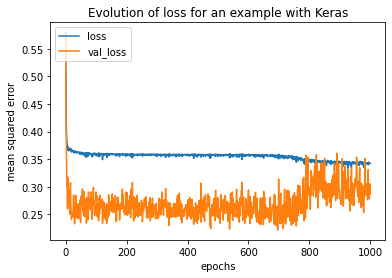

In [9]:
plt.plot(run_losses)
plt.plot(run_val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss for an example with Keras')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.show()

Le code suivant permet de montrer l'exécution de cet exemple avec notre algorithme

100%|██████████| 1000/1000 [00:01<00:00, 747.29it/s]


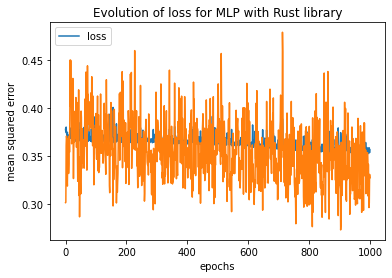

In [10]:
X_random = np.random.uniform(-1, 1.0, (100, 2))
Y_random = np.random.uniform(-1, 1.0, (100, 1))

val_X_random = np.random.uniform(-1, 1.0, (10, 2))
val_Y_random = np.random.uniform(-1, 1.0, (10, 1))
d=[2,3,1]

wrapped_model = MySKLearnMLPRawWrapper(d, iteration_count=len(X_random))
losses = []
val_losses = []
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(X_random, Y_random)
    predicted_y_train=wrapped_model.predict(X_random, 2, 1)
    predicted_y_test=wrapped_model.predict(val_X_random, 2, 1)
    
    loss=mean_squared_error(Y_random, predicted_y_train)
    losses.append(loss)
    
    val_loss = mean_squared_error(val_Y_random, predicted_y_test)
    val_losses.append(val_loss)

plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss'], loc='upper left')
plt.title('Evolution of loss for MLP with Rust library')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.show()

## Tests sur les cas de tests

Les cas de tests on été pour nous un moyen intéressant de voir les différentes façon dont fonctionne les différents algorithmes que nous avons implémenté. Dans le cas du modèle linéaire il ne fonctionnait pas sur le cas du XOR mais nous avons pu remarquer que les points n'étaient pas séparés de la même façon quand on le traitait avec le MLP ou le RBF

100%|██████████| 1000/1000 [00:00<00:00, 1795.32it/s]


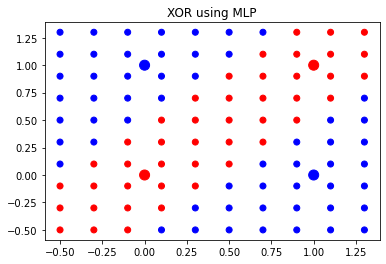

[]

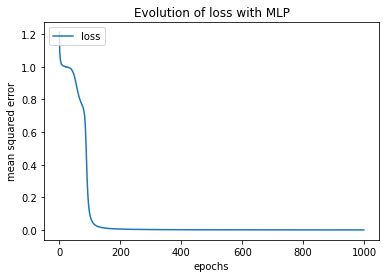

In [14]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])
colors = ["blue" if output >= 0 else "red" for output in Y]
d=[2,2,1]

wrapped_model = MySKLearnMLPRawWrapper(d, alpha=0.001,iteration_count=1000)
losses = []
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(X, Y)
    predicted_y_train=wrapped_model.predict(X, 2, 1)
    loss=mean_squared_error(Y, predicted_y_train)
    losses.append(loss)

test_dataset = [[x1/10, x2 / 10] for x1 in range(-5, 15,2) for x2 in range(-5,15,2)]
predicted_outputs = wrapped_model.predict(test_dataset, 2, 1)
predicted_outputs_colors = ['blue' if label >= 0.0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.title('XOR using MLP')
plt.show()

plt.plot(losses)
plt.legend(['loss'], loc='upper left')
plt.title('Evolution of loss with MLP')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.plot()

100%|██████████| 1000/1000 [00:00<00:00, 2988.39it/s]


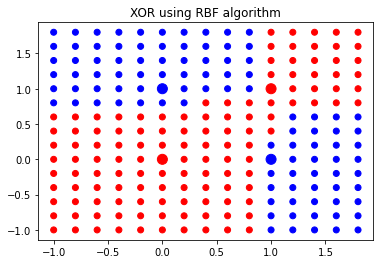

[]

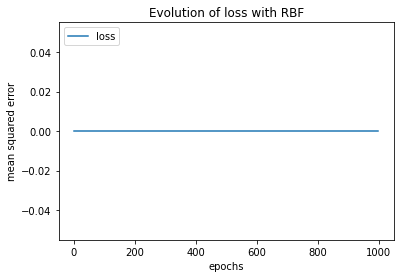

In [15]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])
colors = ["blue" if output >= 0 else "red" for output in Y]

wrapped_model = MySKLearnRBFRawWrapper(4, X, 2, 1, iteration_count=1000)
wrapped_model.lloyd(X)
losses = []
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(X, Y)
    predicted_y_train=wrapped_model.predict(X)
    loss=mean_squared_error(Y, predicted_y_train)
    losses.append(loss)
    
test_dataset = [[x1/10, x2 / 10] for x1 in range(-10, 20,2) for x2 in range(-10,20,2)]
predicted_outputs = wrapped_model.predict(test_dataset)
predicted_outputs_colors = ['blue' if label >= 0.0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.title('XOR using RBF algorithm')
plt.show()

plt.plot(losses)
plt.legend(['loss'], loc='upper left')
plt.title('Evolution of loss with RBF')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.plot()

Nous pouvons remarquer que l'erreur est minimisée au bout de 200 epochs avec le MLP tandis qu'avec le RBF l'erreur commence à 0 et n'est donc pas minimisée. Cela pourrait être dû au nombre de centres qui est constitué de l'ensemble de notre dataset. 

## Application à notre dataset

In [7]:
def import_dataset(file_path):
    with open(file_path) as json_file:
        dataset = json.load(json_file)
    return dataset

def get_pixels(image):
    image = Image.open(image)
    image = image.resize((8, 8))
    im_arr = np.array(image).flatten()
    return np.array(im_arr) / 255.0

### RBF

In [26]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
sample_inputs_len = len(x_train[0])
y_train_action = y_train[:, 1]
y_train_comedy = y_train[:, 2]
y_train_horror = y_train[:, 0]

inputs_len = len(x_train)
outputs_len = len(y_train_horror)
output_dim = 1

In [27]:
wrapped_model_action = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
wrapped_model_comedy = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
wrapped_model_horror = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model_action.lloyd(x_train)
wrapped_model_comedy.lloyd(x_train)
wrapped_model_horror.lloyd(x_train)
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model_action.fit(x_train, y_train_action)
    wrapped_model_comedy.fit(x_train, y_train_comedy)
    wrapped_model_horror.fit(x_train, y_train_horror)

    predicted_y_train_action = wrapped_model_action.predict(x_train)
    predicted_y_train_comedy = wrapped_model_comedy.predict(x_train)
    predicted_y_train_horror = wrapped_model_horror.predict(x_train)
    predicted_y_train = []
    for i in range(0, len(predicted_y_train_horror)):
        predicted_y_train.append([predicted_y_train_horror[i], predicted_y_train_action[i], predicted_y_train_comedy[i]])

    predicted_y_test_action = wrapped_model_action.predict(x_test)

    predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
    predicted_y_test_horror = wrapped_model_horror.predict(x_test)
    predicted_y_test = []

    for i in range(0, len(predicted_y_test_horror)):
        predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_action[i], predicted_y_test_comedy[i]])

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [15:45<00:00,  1.06it/s]


The validation accuracy is 0.45357142857142857


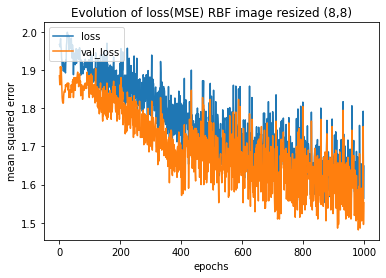

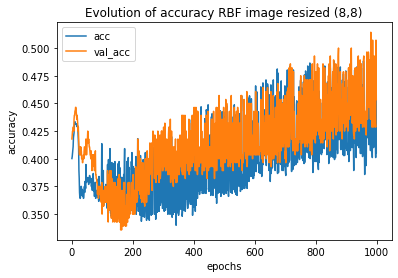

In [28]:
print(f"The validation accuracy is {val_acc}")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss(MSE) RBF image resized (8,8)')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy RBF image resized (8,8)')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

Le RBF, lui, minimise un peu mieux l’erreur que les autres algorithmes qui restent un peu stable mais nous avons toujours de l’underfitting comme dans les algorithmes précédents. Nous avons essayer de changer les paramètres pour essayer de minimiser encore plus cette erreur mais elle reste stable, de même pour l'accuracy. 

<AxesSubplot:>

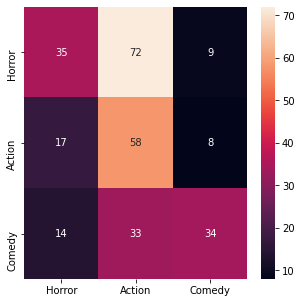

In [29]:
predicted_y_test_action = wrapped_model_action.predict(x_test)
predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
predicted_y_test_horror = wrapped_model_horror.predict(x_test)
predicted_y_test = []
for i in range(0, len(predicted_y_test_horror)):
    predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_action[i], predicted_y_test_comedy[i]])
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Action", "Comedy"]], columns = [i for i in ["Horror", "Action", "Comedy"]])
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True)

Nous avons réalisé des matrices de confusion afin de mieux visualiser nos résultats. Nous remarquons, qu'avec le RBF, que majoritairement les affiches d'action se confonde beaucoup avec celle d'horreur (seulement 36% des affiches d'action sont correctement prédites contre 54% pour l'horreur). 47% des affiches d'action sont prédites en horreur ce qui représente pratiquement la moitié. 

In [25]:
#destroy
wrapped_model_action.destroy()
wrapped_model_comedy.destroy()
wrapped_model_horror.destroy()

### MLP

In [22]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train)
y_test = np.array(y_test)

In [38]:
sample_inputs_len = len(x_train[0])
d = [sample_inputs_len, 2]
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model = MySKLearnMLPRawWrapper(d, alpha=0.1,iteration_count=len(x_train))
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(x_train, y_train)
    predicted_y_train = wrapped_model.predict(x_train, sample_inputs_len, 3)
    predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 3)

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [02:25<00:00,  6.86it/s]


0.33214285714285713


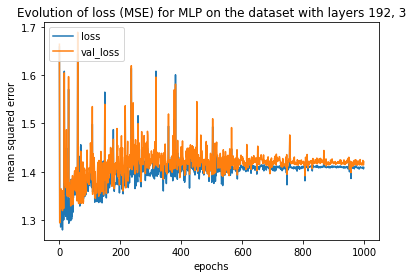

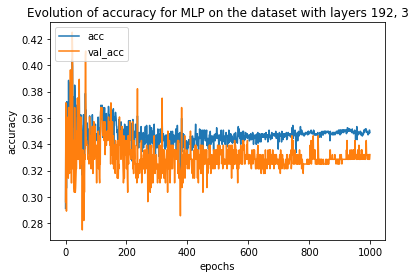

In [39]:
print(val_accs[-1])
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss (MSE) for MLP on the dataset with layers 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy for MLP on the dataset with layers 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

Lorsque nous avons utilisé le MLP pour notre dataset nous avons essayé plusieurs fois avec des couches cachées ou sans mais nous sommes arrivés à des résultats similaires. Par soucis de rapidité, nous sommes donc restés sur un MLP sans couche cachée. Nous pouvons voir que l'erreur ainsi que l'accuracy reste stable au bout d'environ 400 epochs. L'erreur atteint des niveaux plus bas que pour le RBF mais l'accuracy ne dépasse pas 0.33 contrairement au RBF qui arrive jusqu'à pratiquement 0.5. Nous sommes comme pour le RBF nous sommes dans une situation d'underfitting. Nous avons donc décidé de regarder la matrice de confusion pour expliquer ces résultats. 

<AxesSubplot:>

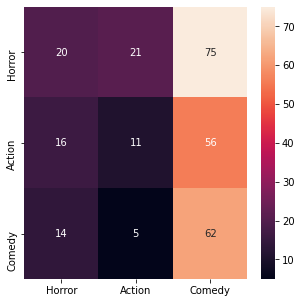

In [40]:
predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 3)
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Action", "Comedy"]], columns = [i for i in ["Horror", "Action", "Comedy"]])
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True)

La matrice de confusion nous explique cette accuracy qui est assez faible. On peut voir que quelques soit le genre, il y a beaucoup d'erreurs. 32% des affiches des comédie, 29% des affiches d'action et 40% des affiches d'horreur sont correctement prédites. 57% des affiches d'action sont prédites en horreur avec ce modèle. 

In [41]:
#destroy
wrapped_model.destroy()

### Modèle linéaire

In [9]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
sample_inputs_len = len(x_train[0])
y_train_action = y_train[:, 1]
y_train_comedy = y_train[:, 2]
y_train_horror = y_train[:, 0]

inputs_len = len(x_train)
outputs_len = len(y_train_horror)
output_dim = 1

In [10]:
wrapped_model_action = MySKLearnLinearModelWrapper(sample_inputs_len)
wrapped_model_comedy = MySKLearnLinearModelWrapper(sample_inputs_len)
wrapped_model_horror = MySKLearnLinearModelWrapper(sample_inputs_len)
losses = []
val_losses = []
accs = []
val_accs = []

for epoch in tqdm.tqdm(range(1000)):
    wrapped_model_action.fit(x_train, y_train_action)
    wrapped_model_comedy.fit(x_train, y_train_comedy)
    wrapped_model_horror.fit(x_train, y_train_horror)

    predicted_y_train_action = wrapped_model_action.predict(x_train, sample_inputs_len)
    predicted_y_train_comedy = wrapped_model_comedy.predict(x_train, sample_inputs_len)
    predicted_y_train_horror = wrapped_model_horror.predict(x_train, sample_inputs_len)

    predicted_y_train = []
    for i in range(0, len(predicted_y_train_horror)):
        predicted_y_train.append(
            [predicted_y_train_horror[i], predicted_y_train_action[i], predicted_y_train_comedy[i]])

    predicted_y_test_action = wrapped_model_action.predict(x_test, sample_inputs_len)
    predicted_y_test_comedy = wrapped_model_comedy.predict(x_test, sample_inputs_len)
    predicted_y_test_horror = wrapped_model_horror.predict(x_test, sample_inputs_len)

    predicted_y_test = []
    for i in range(0, len(predicted_y_test_horror)):
        predicted_y_test.append(
            [predicted_y_test_horror[i], predicted_y_test_action[i], predicted_y_test_comedy[i]])
    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [06:52<00:00,  2.43it/s]


0.425


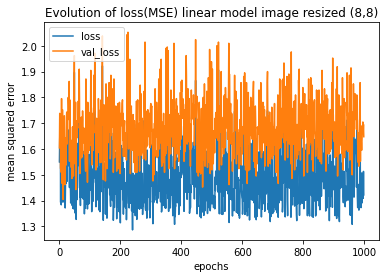

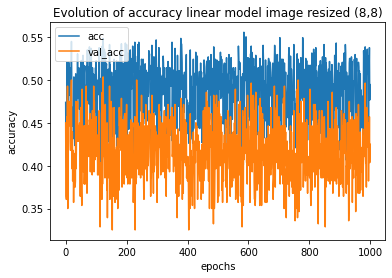

In [11]:
print(val_accs[-1])
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss(MSE) linear model image resized (8,8)')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy linear model image resized (8,8)')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

Le modèle linéaire est le modèle qui nous a le plus surprise en terme de résultats. L'erreur et l'accuracy restent toujours au même niveau mais nous avons une accuracy qui est plus élevé, à la fin de l'entrainement, que le MLP.  

<AxesSubplot:>

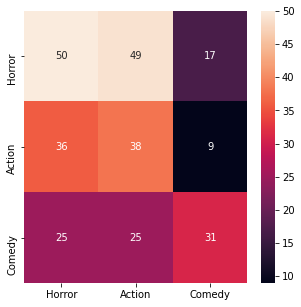

In [13]:
predicted_y_test_action = wrapped_model_action.predict(x_test, sample_inputs_len)
predicted_y_test_comedy = wrapped_model_comedy.predict(x_test, sample_inputs_len)
predicted_y_test_horror = wrapped_model_horror.predict(x_test, sample_inputs_len)
predicted_y_test = []
for i in range(0, len(predicted_y_test_horror)):
    predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_action[i], predicted_y_test_comedy[i]])
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Action", "Comedy"]], columns = [i for i in ["Horror", "Action", "Comedy"]])
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True)

La matrice de confusion nous donne des résultats assez similaires à celui du RBF avec 54% de comédie, 33% d'action et 45% d'horreur correctement prédis. 43% des affiches d'action sont prédites en horreur

In [ ]:
wrapped_model_action.destroy()
wrapped_model_comedy.destroy()
wrapped_model_horror.destroy()

## Test en enlevant les affiches d'action

Nous avons voulu tester d'enlever un des genres pour vérifier pourquoi la performance des algorithmes étaient aussi basse. La chose à laquelle nous avons pensé par rapport aux résultats précédents est que beaucoup d'affiches d'action sont classifié en horreur. Mais quels seraient les résultats si on enlevait les affiches d'action ? 

In [23]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
sample_inputs_len = len(x_train[0])
y_train_comedy = y_train[:, 2]
y_train_horror = y_train[:, 0]
y_train = [[i[0], i[2]] for i in y_train]
y_test = [[i[0], i[2]] for i in y_test]

In [24]:
inputs_len = len(x_train)
outputs_len = len(y_train_horror)
output_dim = 1
wrapped_model_comedy = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
wrapped_model_horror = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model_comedy.lloyd(x_train)
wrapped_model_horror.lloyd(x_train)
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model_comedy.fit(x_train, y_train_comedy)
    wrapped_model_horror.fit(x_train, y_train_horror)

    predicted_y_train_comedy = wrapped_model_comedy.predict(x_train)
    predicted_y_train_horror = wrapped_model_horror.predict(x_train)
    predicted_y_train = []
    for i in range(0, len(predicted_y_train_horror)):
        predicted_y_train.append([predicted_y_train_horror[i], predicted_y_train_comedy[i]])


    predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
    predicted_y_test_horror = wrapped_model_horror.predict(x_test)
    predicted_y_test = []

    for i in range(0, len(predicted_y_test_horror)):
        predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_comedy[i]])

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [10:47<00:00,  1.54it/s]


The validation accuracy of the RBF with two classes is 0.6321428571428571


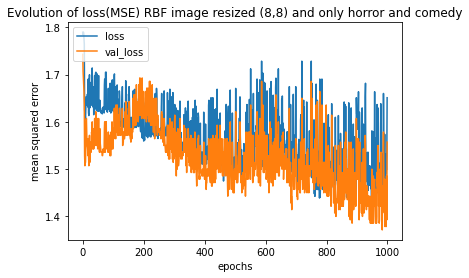

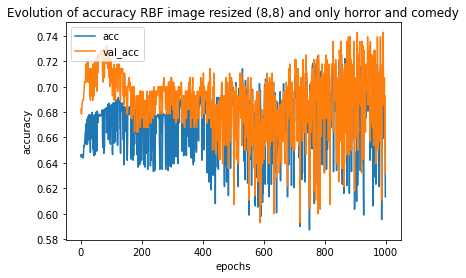

In [25]:
print(f"The validation accuracy of the RBF with two classes is {val_accs[-1]}")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss(MSE) RBF image resized (8,8) and only horror and comedy')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy RBF image resized (8,8) and only horror and comedy')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

Dans ce cas de figurre, nous obtenons une erreur qui est minimisé au même niveau qu'avec 3 genres dans le dataset mais l'accuracy est meilleure que dans le cas précédent. 

<AxesSubplot:>

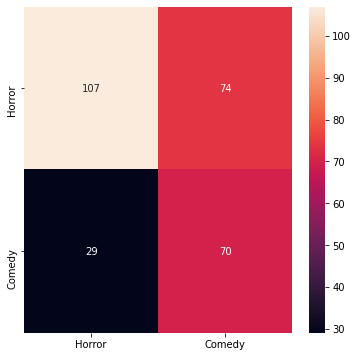

In [28]:
predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
predicted_y_test_horror = wrapped_model_horror.predict(x_test)
predicted_y_test = []
for i in range(0, len(predicted_y_test_horror)):
    predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_comedy[i]])
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Comedy"]], columns = [i for i in ["Horror", "Comedy"]])
plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True,fmt='g')

En analysant la matrice de confusion, nous avons remarqué que les résultats sont bien meilleur pour l'horreur avec 78% de bonne prédiction mais que la comédie commence à se confondre avec les affiches d'horreur

In [29]:
#destroy
wrapped_model_comedy.destroy()
wrapped_model_horror.destroy()

In [8]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = [[i[0], i[2]] for i in y_train]
y_test = [[i[0], i[2]] for i in y_test]

In [12]:
sample_inputs_len = len(x_train[0])
d = [sample_inputs_len, 2]
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model = MySKLearnMLPRawWrapper(d, alpha=0.1,iteration_count=len(x_train))
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(x_train, y_train)
    predicted_y_train = wrapped_model.predict(x_train, sample_inputs_len, 2)
    predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 2)

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [02:10<00:00,  7.67it/s]


The validation accuracy of the MLP with two classes is 0.7


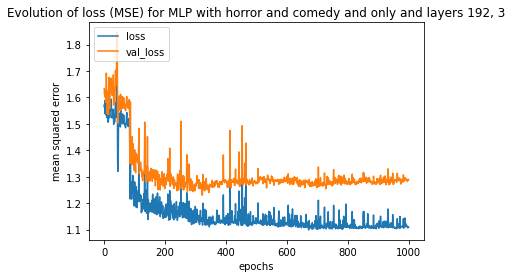

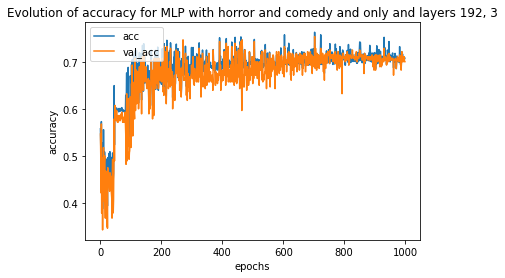

In [15]:
print(f"The validation accuracy of the MLP with two classes is {val_accs[-1]}")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss (MSE) for MLP with horror and comedy and only and layers 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy for MLP with horror and comedy and only and layers 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

Ici, le MLP performe bien mieux, avec une accuracy qui augmente jusqu'à 70% et une erreur qui est minimisé en dessous des niveaux que nousa vons pu voir dans tous les cas de figure précédent. 

<AxesSubplot:>

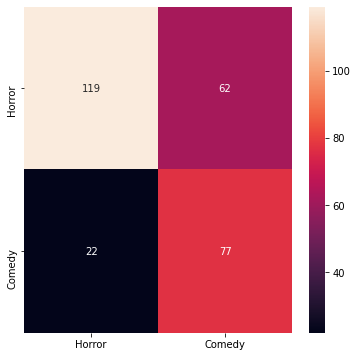

In [14]:
predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 2)
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Comedy"]], columns = [i for i in ["Horror", "Comedy"]])
plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True, fmt='g')

La matrice de confusion nous confirme ces résultats en nous montrant bien que à 84% pour les affiches d'horreur et à 55% pour les affiches de comédie, nous obtenos une bonne classification

In [16]:
#destroy
wrapped_model.destroy()

## Conclusion

Durant cette partie nous avons pu rencontrer plus de problème, de la réalisation des algorithmes aux tests sur notre dataset. 
Les tests que nous avons réalisés sur notre dataset nous ont amené à nous poser une question : pourquoi nos résultats ne sont pas concluants ?   
Nous avons émis plusieurs hypothèses. Le fait que les affiches d’action et horreur se confondent peut venir du fait que l’on ne passe que les pixels de nos affiches. Les affiches d’horreur sont très codifiées et ont des couleurs similaires. Les affiches d’action souvent se rapproche du code couleur des affiches d’horreur. Nous aurions pu choisir de passer plus de paramètres, comme le titre du film, mais cela aurait peut-être facilité la classification. Peut-être nous aurions pu choisir trois genres totalement différents mais l’utilisation du machine learning aurait été peut-être trop facile. 
Nous avons remarqué aussi dans nos tests que le MLP fonctionne bien mieux avec deux genres totalement opposé, de même pour le RBF. 
Notre cas d’usage avec les paramètres que nous passons à l’algorithme est, selon nous, trop difficile pour le machine learning ce qui expliquerait les résultats très faible.